**Script name** : Global Planner

**Description** : Multi-agent payload transport global planner based on RRT.

**Author**      : Swapnil Kalhapure

**Email**       : kalhapure.swapnil@gmail.com

## Imports

In [1]:
import cv2 
import math
import time
import rospy
import tf2_ros
import numpy as np
from PIL import Image
import tf2_geometry_msgs  
import random
from matplotlib import path
from nav_msgs.msg import Path
from scipy import interpolate
from numpy.linalg import norm
import matplotlib.pyplot as plt
from nav_msgs.msg import Odometry
from scipy.spatial import ConvexHull
import matplotlib.patches as patches
from nav_msgs.msg import OccupancyGrid
from geometry_msgs.msg import PoseStamped
from matplotlib.patches import Polygon
from geometry_msgs.msg import PoseStamped
from scipy.ndimage.morphology import distance_transform_edt as bwdist
from scipy.ndimage.morphology import grey_dilation

## Global variables

In [2]:
res_remap = 0.04

map_x = 0.0
map_y = 0.0
map_org_x = 0.0
map_org_y = 0.0
map_res = 0.0

mapdata = None
orgmapdata = None

current_xy = None
path_pub = None


## Helper Functions

In [3]:
def meters2grid(pose_m):
    pose_on_grid = np.array((np.array(pose_m) - [map_org_x, map_org_y])/ map_res)
    pose_on_grid[1] = map_y - pose_on_grid[1] 
    return pose_on_grid

In [4]:
def grid2meters(pose_grid):
    x = pose_grid[0] * (map_res) + map_org_x #+ map_res /2
    y = (map_y - pose_grid[1]) * (map_res) + map_org_y #+ map_res /2
    a = []
    a.append(float(x))
    a.append(float(y))
    return a

In [5]:
def get_line(x1, y1, x2, y2):
    x1 = int(x1)
    y1 = int(y1)
    x2 = int(x2)
    y2 = int(y2)
    points = []
    issteep = abs(y2-y1) > abs(x2-x1)
    if issteep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
    rev = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        rev = True
    deltax = x2 - x1
    deltay = abs(y2-y1)
    error = int(deltax / 2)
    y = y1
    ystep = None
    if y1 < y2:
        ystep = 1
    else:
        ystep = -1
    for x in range(x1, x2 + 1):
        if issteep:
            points.append((y, x))
        else:
            points.append((x, y))
        error -= deltay
        if error < 0:
            y += ystep
            error += deltax
    # Reverse the list if the coordinates were reversed
    if rev:
        points.reverse()
    return points

In [6]:
def path_smoothing(path):
    current_point = 0 
    mapd = mapdata
    smoothedpath = []
    smoothedpath.append([path[current_point][0],path[current_point][1]])
    while (current_point <= len(path)):
        org_current_point = current_point
        for j in range(current_point,len(path)):
            point_lists = get_line(path[current_point][0],path[current_point][1],path[j][0],path[j][1])
            a = 0
            for i in range(len(point_lists)):
                if (mapd[point_lists[i][1],point_lists[i][0]] <= 0.0):
                    a = 1
                    current_point = j 
                    smoothedpath.append([path[j][0],path[j][1]])
                    break
            if (a == 1):
                break
        if (org_current_point == current_point):
            break
    smoothedpath.append([path[-1][0],path[-1][1]])
    return smoothedpath

## RRT path planner

In [7]:
class RRT:
    """
    Class for RRT planning
    """
    class Node:
        """
        RRT Node
        """
        def __init__(self, x, y):
            self.x = x
            self.y = y
            self.path_x = []
            self.path_y = []
            self.parent = None
    def __init__(self,
                 start,
                 goal,
                 map_grid,
                 rand_area,
                 expand_dis=100,
                 path_resolution=10,
                 goal_sample_rate=5,
                 max_iter=5900):
        """
        Setting Parameter
        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:Random Sampling Area [min,max]
        """
        self.start = self.Node(start[0], start[1])
        self.end = self.Node(goal[0], goal[1])
        self.min_rand = rand_area[0]
        self.max_rand = rand_area[1]
        self.expand_dis = expand_dis
        self.path_resolution = path_resolution
        self.goal_sample_rate = goal_sample_rate#
        self.grid_map = map_grid
        self.max_iter = max_iter
        self.node_list = []

    def planning(self, animation=True):
        """
        rrt path planning

        animation: flag for animation on or off
        """
        self.node_list = [self.start]
        for i in range(self.max_iter):
            rnd_node = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd_node)
            nearest_node = self.node_list[nearest_ind]

            new_node = self.steer(nearest_node, rnd_node, self.expand_dis)

            if self.check_collision(new_node,self.grid_map):
                self.node_list.append(new_node)

            if animation and i % 5 == 0:
                self.draw_graph(rnd_node)

            if self.calc_dist_to_goal(self.node_list[-1].x,
                                      self.node_list[-1].y) <= self.expand_dis:
                final_node = self.steer(self.node_list[-1], self.end,
                                        self.expand_dis)
                if self.check_collision(final_node,self.grid_map):
                    return self.generate_final_course(len(self.node_list) - 1)

            if animation and i % 5:
                self.draw_graph(rnd_node)

        return None  # cannot find path

    def steer(self, from_node, to_node, extend_length=float("inf")):

        new_node = self.Node(from_node.x, from_node.y)
        d, theta = self.calc_distance_and_angle(new_node, to_node)

        new_node.path_x = [new_node.x]
        new_node.path_y = [new_node.y]

        if extend_length > d:
            extend_length = d

        n_expand = math.floor(extend_length / self.path_resolution)

        for _ in range(n_expand):
            new_node.x += self.path_resolution * math.cos(theta)
            new_node.y += self.path_resolution * math.sin(theta)
            new_node.path_x.append(new_node.x)
            new_node.path_y.append(new_node.y)

        d, _ = self.calc_distance_and_angle(new_node, to_node)
        if d <= self.path_resolution:
            new_node.path_x.append(to_node.x)
            new_node.path_y.append(to_node.y)
            new_node.x = to_node.x
            new_node.y = to_node.y

        new_node.parent = from_node

        return new_node

    def generate_final_course(self, goal_ind):
        path = [[self.end.x, self.end.y]]
        node = self.node_list[goal_ind]
        while node.parent is not None:
            path.append([node.x, node.y])
            node = node.parent
        path.append([node.x, node.y])

        return path

    def calc_dist_to_goal(self, x, y):
        dx = x - self.end.x
        dy = y - self.end.y
        return math.hypot(dx, dy)

    def get_random_node(self):
        if random.randint(0, 10) > self.goal_sample_rate:
            rnd = self.Node(
                int(random.uniform(self.min_rand, self.max_rand)),
                int(random.uniform(self.min_rand, self.max_rand)))
        else: 
            rnd = self.Node(self.end.x, self.end.y)
        return rnd

    def draw_graph(self, drawthis, rnd=None):
        plt.figure(figsize=(10,10))
        plt.clf()
        plt.gcf().canvas.mpl_connect(
            'key_release_event',
            lambda event: [exit(0) if event.key == 'escape' else None])
        if rnd is not None:
            plt.plot(rnd.x, rnd.y, "^k")
        for node in self.node_list:
            if node.parent:
                plt.plot(node.path_x, node.path_y, "-g")

        plt.imshow(drawthis)
        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")
        plt.grid(True)
        plt.pause(0.0001)

    @staticmethod
    def get_nearest_node_index(node_list, rnd_node):
        dlist = [(node.x - rnd_node.x)**2 + (node.y - rnd_node.y)**2
                 for node in node_list]
        minind = dlist.index(min(dlist))

        return minind

    @staticmethod
    def check_collision(node,grid_map):
        if node is None:
            return False
        if (grid_map[int(node.y),int(node.x)] != 0.0):
            return True
        else:
            return False

    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = math.hypot(dx, dy)
        theta = math.atan2(dy, dx)
        return d, theta

## ROS Code

found path!!


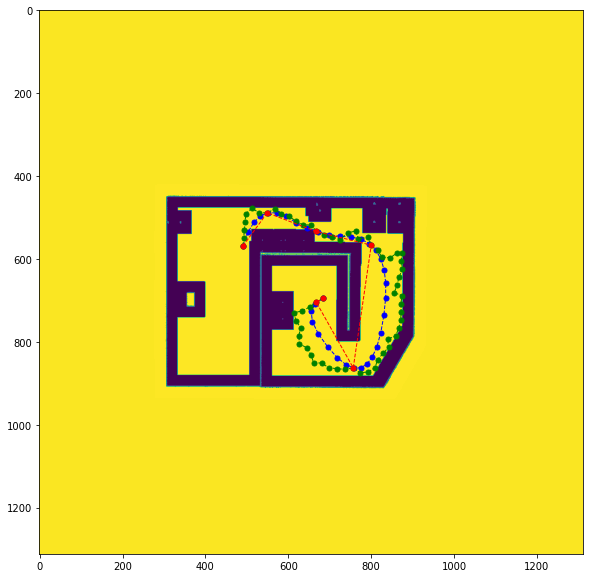

35
35
found path!!


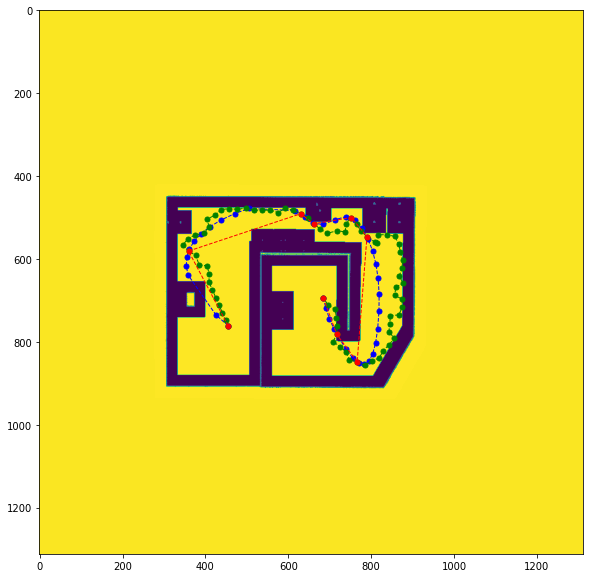

45
38
Cannot find path
found path!!


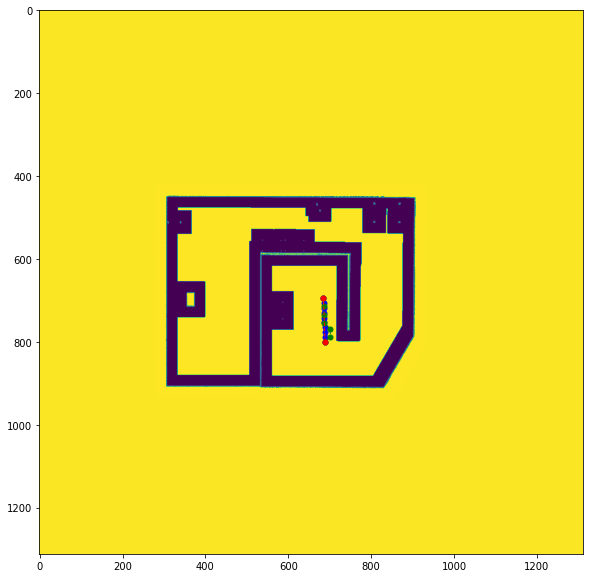

10
10
found path!!


/home/scifiswapnil/.local/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:300: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


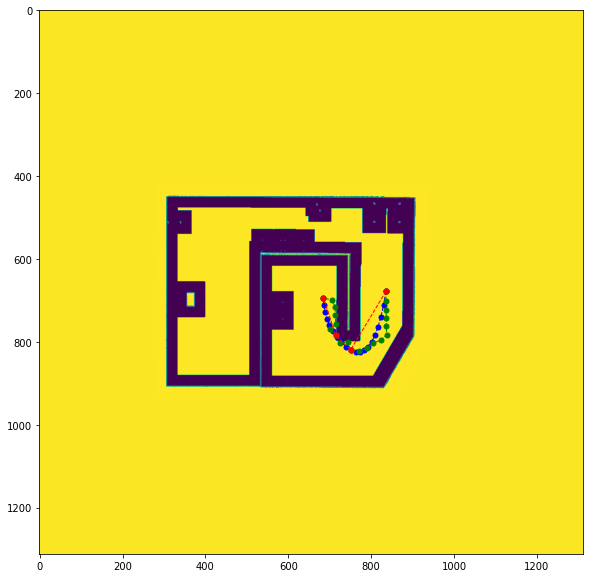

20
20


In [8]:
def map_callback(data):
    global mapdata
    global orgmapdata
    global map_x
    global map_y
    global map_org_x
    global map_org_y
    global map_res
    global res_remap
    
    map_x = data.info.width
    map_y = data.info.height
    map_org_x = data.info.origin.position.x
    map_org_y = data.info.origin.position.y
    map_res = data.info.resolution
    orgmapdata = np.asarray(data.data).reshape(data.info.height,data.info.width).astype(np.uint8)
    orgmapdata = np.flip(orgmapdata,0)
    mapdata = orgmapdata
    mapdata = np.where(mapdata<254,mapdata,0)
    mapdata = grey_dilation(mapdata,size=(int(res_remap*map_y),int(res_remap*map_x)))
    mapdata = np.invert(mapdata)
    mapdata = cv2.threshold(mapdata, 200, 255, cv2.THRESH_BINARY)[1]

#     plt.figure(figsize=(10,10))
#     plt.grid()
#     plt.imshow(mapdata)
#     plt.xlabel('X, m')
#     plt.ylabel('Y, m')
#     plt.show() 

def callbackodom(data):
    global current_xy
    current_xy = data
    
def callbackgoal(data):
    global xy_start
    global path_pub
    global orgpath

    
    tfbuffer = tf2_ros.Buffer()
    listener = tf2_ros.TransformListener(tfbuffer)
    
    t_a_b = tfbuffer.lookup_transform("map",current_xy.header.frame_id, rospy.Time(0), rospy.Duration(10.0))
    start1 = tf2_geometry_msgs.do_transform_pose(current_xy.pose, t_a_b)
    
    t_a_c = tfbuffer.lookup_transform("map",data.header.frame_id, rospy.Time(0), rospy.Duration(10.0))
    goal1 = tf2_geometry_msgs.do_transform_pose(data, t_a_c)
    
    start = meters2grid((start1.pose.position.x, start1.pose.position.y))
    goal = meters2grid((goal1.pose.position.x, goal1.pose.position.y))
    
    rrt = RRT(
        start=[start[0],start[1]],
        goal=[goal[0],goal[1]],
        rand_area=[50, 1200],
        map_grid=mapdata,
        expand_dis=20,
        path_resolution=5,
        goal_sample_rate=1,
        max_iter=15000)
    path = rrt.planning(animation=False)
#     rrt.draw_graph(orgmapdata+mapdata)
    if path is None:
        print("Cannot find path")
    else:
        print("found path!!")
        orgpath = path
        decomp_X = []
        decomp_Y = []
        Sdecomp_X = []
        Sdecomp_Y = []
        smoothpath = path_smoothing(orgpath)
        for i in range(len(orgpath)):
            decomp_X.append(orgpath[i][0])
            decomp_Y.append(orgpath[i][1])
        for j in range(len(smoothpath)):
            Sdecomp_X.append(smoothpath[j][0])
            Sdecomp_Y.append(smoothpath[j][1])
        if (len(Sdecomp_X) <= 2):
            f, u = interpolate.splprep([Sdecomp_X,Sdecomp_Y],s=0.05,k=1)
        else :
            f, u = interpolate.splprep([Sdecomp_X,Sdecomp_Y],s=0.05,k=2)
        xsmooth, ysmooth = interpolate.splev(np.linspace(0, 1.0, len(Sdecomp_X)*5), f)
        ros_path = np.vstack((xsmooth,ysmooth))
        
        tt=[]
        for i in range(len(ros_path[0])):
            if (mapdata[int(ros_path[1][i]),int(ros_path[0][i])] > 0):
                tt.append([ros_path[0][i],ros_path[1][i]])
        ttt = np.array(tt) 
    
#         plt.figure(figsize=(10,10))
#         plt.imshow(mapdata+orgmapdata)
#         plt.plot(ttt[:,0],ttt[:,1],'bo--',linewidth=1, markersize=5)
#         plt.plot(decomp_X,decomp_Y,'go--',linewidth=1, markersize=5)
#         plt.plot(Sdecomp_X,Sdecomp_Y,'ro--',linewidth=1, markersize=5)
#         plt.show()
        
        rrtsmoothpath = Path()
        rrtsmoothpath.header.frame_id = "map"
        rrtsmoothpath.header.stamp = rospy.Time.now()
        for i in range(1,len(ttt[:,0])+1):
            pose = PoseStamped()
            ans = grid2meters([ttt[-i][0],ttt[-i][1]])
            pose.header = rrtsmoothpath.header
            pose.pose.position.x = ans[0] 
            pose.pose.position.y = ans[1]
            pose.pose.orientation.w = 1
            rrtsmoothpath.poses.append(pose)            
        path_pub.publish(rrtsmoothpath)

rospy.init_node('GlobalPlanner', anonymous=True)
path_pub = rospy.Publisher('/jackal0/global_path', Path, queue_size=10)
rospy.Subscriber("/map", OccupancyGrid, map_callback)
rospy.Subscriber("/jackal0/odometry/local_filtered", Odometry, callbackodom)
rospy.Subscriber("/move_base_simple/goal", PoseStamped, callbackgoal)

decomp_X = []
decomp_Y = []
Sdecomp_X = []
Sdecomp_Y = []
smoothpath = path_smoothing(orgpath)
for i in range(len(orgpath)):
    decomp_X.append(orgpath[i][0])
    decomp_Y.append(orgpath[i][1])
for j in range(len(smoothpath)):
    Sdecomp_X.append(smoothpath[j][0])
    Sdecomp_Y.append(smoothpath[j][1])
if (len(Sdecomp_X) <= 2):
    f, u = interpolate.splprep([Sdecomp_X,Sdecomp_Y],s=0.05,k=1)
else :
    f, u = interpolate.splprep([Sdecomp_X,Sdecomp_Y],s=0.05,k=2)
xsmooth, ysmooth = interpolate.splev(np.linspace(0, 1.0, len(Sdecomp_X)*5), f)
ros_path = np.vstack((xsmooth,ysmooth))

# stest = np.array(path_smoothing(np.swapaxes(ros_path,0,1)))
plt.figure(figsize=(10,10))
plt.imshow(mapdata)
tt=[]
   
# plt.plot(ros_path[0],ros_path[1],'bo--',linewidth=1, markersize=5)
plt.plot(ttt[:,0],ttt[:,1],"yo--")
# plt.plot(decomp_X,decomp_Y,'go--',linewidth=1, markersize=5)
# plt.plot(Sdecomp_X,Sdecomp_Y,'ro--',linewidth=1, markersize=5)
plt.show()

### Testing

t = orgmapdata
t = np.where(t<254,t,0)
t = grey_dilation(t,size=(int(res_remap*map_y),int(res_remap*map_x)))
t = np.invert(t)
t = cv2.threshold(t, 200, 255, cv2.THRESH_BINARY)[1]

plt.figure(figsize=(10,10))
plt.imshow(t)
plt.show()


from sklearn.preprocessing import scale,  minmax_scale
X = scale( bdist, axis=0, with_mean=True, with_std=True, copy=True )
X = minmax_scale(bdist, feature_range=(0,255))
X = X.astype(np.uint8)
cv2.imshow("t",cv2.resize(X,(300,300)))
cv2.waitKey(0)
cv2.destroyAllWindows()


plt.figure(figsize=(15,15))
plt.imshow(mapdata+orgmapdata)
decomp_X = []
decomp_Y = []
Sdecomp_X = []
Sdecomp_Y = []
smoothpath = path_smoothing(orgpath)
for i in range(len(orgpath)):
    decomp_X.append(orgpath[i][0])
    decomp_Y.append(orgpath[i][1])
for j in range(len(smoothpath)):
    Sdecomp_X.append(smoothpath[j][0])
    Sdecomp_Y.append(smoothpath[j][1])
f, u = interpolate.splprep([Sdecomp_X,Sdecomp_Y], s=0.1, k=2)
xsmooth, ysmooth = interpolate.splev(np.linspace(0, 1.0, len(Sdecomp_X)*5), f)
ros_path = np.vstack((
    xsmooth,ysmooth))
model2 = np.poly1d(np.polyfit(decomp_X,decomp_Y, 2))
plt.plot(model2[0],model2[1],'b0--',linewidth=1, markersize=5)
plt.plot(ros_path[0],ros_path[1],'bo--',linewidth=1, markersize=5)
plt.plot(decomp_X,decomp_Y,'go--',linewidth=1, markersize=5)
plt.plot(Sdecomp_X,Sdecomp_Y,'ro--',linewidth=1, markersize=5)
plt.show()


polyline = np.linspace(1, 15, 50)
model2(polyline)

def check_path_collision(s,e):
    mapd = mapdata + orgmapdata
    point_lists = get_line(path[s][0],path[s][1],path[e+1][0],path[e+1][1])
    for i in range(len(point_lists)):
        if (mapd[point_lists[i][1],point_lists[i][0]] == 0.0):
            return True
    return False

def path_smoothing_sec(path):
    current_point = 0 
    mapd = mapdata + orgmapdata
    smoothedpath = []
    smoothedpath.append([path[current_point][0],path[current_point][1]])
    for i in range(0,len(path)):
        for j in range(i,len(path)):
            print (i,j)
    return smoothedpath

current_point = 0 
while( current_point < len(path)):
    for j in range(current_point,len(path)):
        if (check_path_collision(current_point,j)):
            print("bomb : " + str(current_point) + " :"+str(j))
            current_point = j 
            break

path

### Garbage

rrt = RRT(
    start=[700,800],
    goal=[905,700],
    rand_area=[0, 1500],
    map_grid=mapdata,
    expand_dis=20,
    path_resolution=5,
    goal_sample_rate=1,
    max_iter=10000)
path = rrt.planning(animation=False)
rrt.draw_graph()
if path is None:
    print("Cannot find path")
else:
    print("found path!!")


smoothedpath = path_smoothing(path)
print(smoothedpath)
plt.imshow(mapdata)
plt.plot([x for (x, y) in path], [y for (x, y) in path], '-r')
plt.plot([x for (x, y) in smoothedpath], [
    y for (x, y) in smoothedpath], '-g')
plt.grid(True)
plt.show()

x_start = meters2grid([0,0.8])
x_goal = meters2grid([0,0.9522])
plt.figure(figsize=(16,16))
plt.grid()
plt.imshow(map_grid)
plt.xlabel('X, m')
plt.ylabel('Y, m')
plt.plot(x_start[0],x_start[1],'bo', markersize=5, label='start')
plt.plot(x_goal[0],x_goal[1],'go', markersize=5, label='goal')
plt.legend()
plt.show()

map_x = odata.info.width
map_y = odata.info.height
map_org_x = odata.info.origin.position.x
map_org_y = odata.info.origin.position.y
map_res = odata.info.resolution
res_remap = 0.05

test = np.asarray(odata.data).reshape(odata.info.height,odata.info.width).astype(np.uint8)
test = np.flip(test,0)
kernel = np.ones((int(res_remap*map_y),int(res_remap*map_x)),np.uint8)
test = cv2.dilate(test,kernel,iterations = 1)
test = np.invert(test)
test = np.where(test<250,0,test)
plt.figure(figsize=(15,15))
plt.grid()
plt.imshow(test)
plt.xlabel('X, m')
plt.ylabel('Y, m')
plt.show() y
cv2.imshow("window_name", cv2.resize(test, (500,500), interpolation = cv2.INTER_AREA))
cv2.waitKey(0) 
cv2.destroyAllWindows() 

plt.scatter(rrp[:,0], rrp[:,1])
plt.plot(xint, yint)
plt.show()
plt.plot([x for (x, y) in ros_path], [y for (x, y) in ros_path], '-r')
plt.grid(True)
plt.show()

def get_line(x1, y1, x2, y2):
    points = []
    issteep = abs(y2-y1) > abs(x2-x1)
    if issteep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
    rev = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        rev = True
    deltax = x2 - x1
    deltay = abs(y2-y1)
    error = int(deltax / 2)
    y = y1
    ystep = None
    if y1 < y2:
        ystep = 1
    else:
        ystep = -1
    for x in range(x1, x2 + 1):
        if issteep:
            points.append((y, x))
        else:
            points.append((x, y))
        error -= deltay
        if error < 0:
            y += ystep
            error += deltax
    # Reverse the list if the coordinates were reversed
    if rev:
        points.reverse()
    return points


get_line(0,0,10,100)

map_x = 1536.0 # in pixels
map_y = 992.0 # in pixels
map_org_x = -20.88
map_org_y = -10.0
map_res = 0.019999999552965164 # in meters
res_remap = 0.05

im = Image.open("/home/scifiswapnil/Desktop/jackal_ws/src/jackal_workspace/map/stage_two.pgm")
map_grid = np.asarray(im)
plt.figure(figsize=(16,16))
plt.grid()
plt.imshow(map_grid)
plt.xlabel('X, m')
plt.ylabel('Y, m')
plt.show()
map_grid = np.where(map_grid<250, map_grid,255)
map_grid = np.where(map_grid>205, map_grid, 0)
map_grid = np.invert(map_grid)
kernel = np.ones((int(res_remap*map_y),int(res_remap*map_x)),np.uint8)
map_grid = cv2.dilate(map_grid,kernel,iterations = 1)
map_grid = np.invert(map_grid)

cv2.imshow("window_name", cv2.resize(map_grid, (500,500), interpolation = cv2.INTER_AREA))
cv2.waitKey(0) 
cv2.destroyAllWindows() 

print(map_grid.size)
print(map_x*map_y)
print("------------------------")
print("pixel space x = ",map_x)
print("pixel space y = ",map_y)
print("pixel space resolution = ",map_res,"meters per pixel")
print("pixel space origin = 0,0 (top left corner)")
print("------------------------")
print("in mtrs real world min x = ",-((map_x*map_res))/2)
print("in mtrs real world max x = ",((map_x*map_res))/2)
print("in mtrs real world min y = ",-((map_y*map_res))/2)
print("in mtrs real world max y = ",((map_y*map_res))/2)
print("------------------------")
plt.figure(figsize=(16,16))
plt.grid()
plt.imshow(map_grid)
plt.xlabel('X, m')
plt.ylabel('Y, m')
plt.show()